In this notebook I tried my hand on segment_anything. 


In [77]:
import os
import json
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [18]:
sam_checkpoint = "D:\\CODE\\segment-anything\\sam_vit_h.pth"
model_type = "vit_h"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [17]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=100):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='.', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='.', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

In [45]:
image_path = 'train'

We will be using only 5 examples from training set.

In [74]:
def image_loader(image_folder):
    images = []
    image_list = os.listdir(image_folder)[:5]
    print(image_list)
    for image in image_list:
        image = cv2.imread(os.path.join(image_folder, image))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = cv2.resize(image, (920,720))
        images.append(image)
    return images

The image we will be using

['0.png', '1.png', '10.png', '100.png', '101.png']
(1372, 2138, 3)


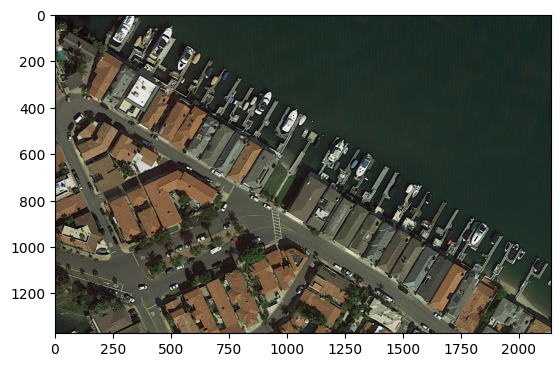

In [100]:
images = image_loader(image_path)
image = images[3]
print(image.shape)
map_img = np.zeros((image.shape[0], image.shape[1], 3))
plt.imshow(image)
plt.axis('on')
plt.show()

In [101]:
predictor.set_image(image)

In [102]:
with open(f'{image_path}/metadata.jsonl', 'r') as json_file:
    json_list = list(json_file)

file_name = []
bboxes = []
categories = []
for json_str in json_list:
    result = json.loads(json_str)
#     print(f"result: {result}")
    file_name.append(result['file_name'])
    bboxes.append(result['objects']['bbox'])
    categories.append(result['objects']['categories'])

df_train = pd.DataFrame([file_name,bboxes,categories]).T
df_train.columns = ['image_id','bbox','category']
df_train = df_train.explode(column=['bbox','category']).reset_index(drop=True)

In [103]:
df_train

image_id                      bbox category
0        0.png  [6690, 3599, 7164, 3850]        0
1        0.png  [6772, 3386, 7039, 3546]        0
2        0.png  [6705, 3291, 7060, 3485]        0
3        0.png  [6230, 3442, 6597, 3647]        0
4        0.png    [5501, 790, 5552, 868]        0
...        ...                       ...      ...
19582  255.png  [4766, 3332, 4776, 3366]        0
19583  255.png  [4754, 3336, 4768, 3363]        0
19584  255.png  [6067, 2428, 6121, 2458]        0
19585  255.png  [6031, 1766, 6068, 1789]        0
19586  255.png    [5603, 678, 5622, 711]        0

[19587 rows x 3 columns]

In [104]:
img_id = image_list[3]
img_id

'100.png'

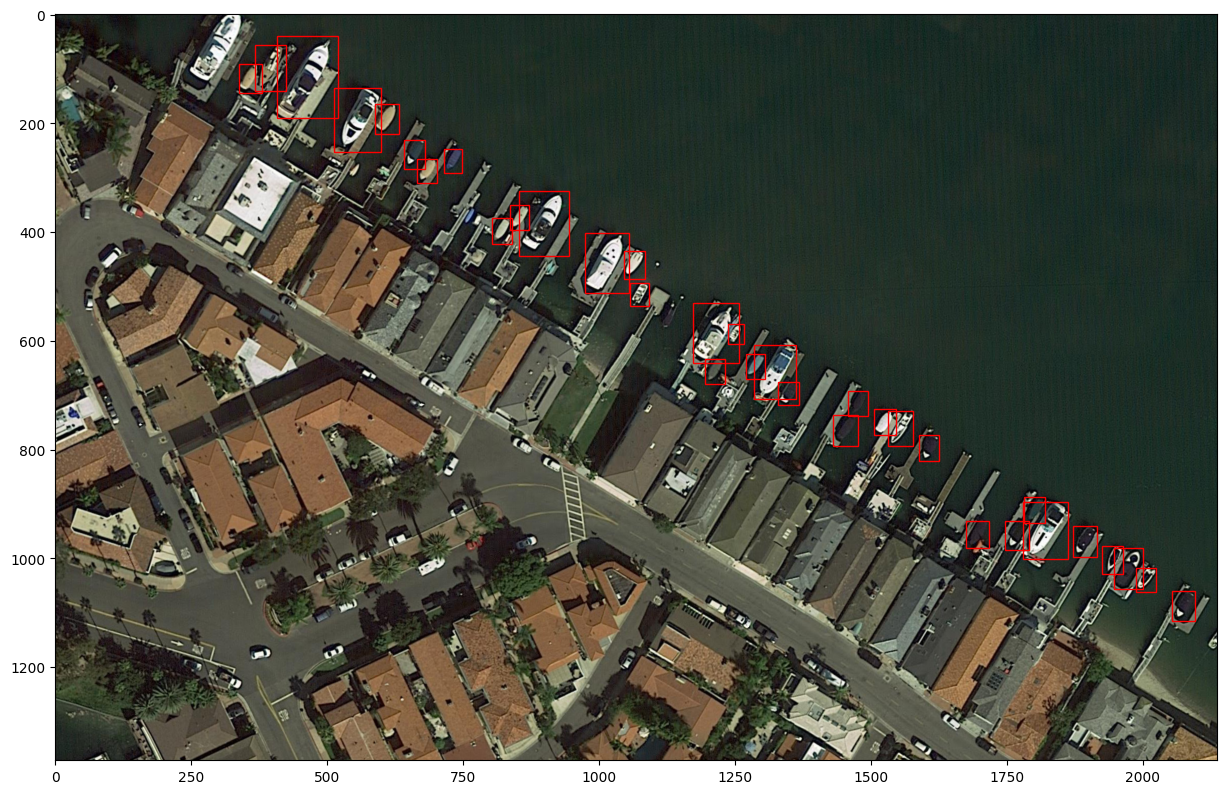

In [105]:
def display_img(img):

    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(img)
    bbox = df_train[df_train.image_id==img_id]['bbox'].tolist()
    
    for b in bbox:    
#         print(b)
        rect = patches.Rectangle((b[0],b[1]),b[2]-b[0],b[3]-b[1], linewidth=1, edgecolor='r', facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

display_img(image)

In [114]:
bbox = df_train[df_train.image_id==img_id]['bbox'].tolist()

In [107]:
import torch
input_boxes = torch.tensor(
bbox, device=predictor.device)

In [108]:
input_boxes

tensor([[ 408,   39,  521,  191],
        [ 588,  164,  633,  219],
        [ 642,  230,  681,  284],
        [ 666,  265,  702,  310],
        [ 716,  248,  748,  291],
        [ 803,  374,  840,  422],
        [ 837,  351,  872,  397],
        [ 854,  324,  945,  444],
        [ 974,  402, 1056,  513],
        [1046,  434, 1084,  487],
        [1174,  530, 1258,  640],
        [1237,  569, 1267,  606],
        [1271,  625, 1306,  670],
        [1286,  608, 1363,  707],
        [1506,  726, 1546,  774],
        [1532,  730, 1578,  794],
        [1589,  774, 1625,  821],
        [1780,  896, 1863, 1002],
        [1872,  941, 1917,  998],
        [1926,  978, 1964, 1028],
        [1947,  982, 2001, 1056],
        [1987, 1017, 2024, 1062],
        [2055, 1061, 2096, 1115],
        [ 513,  136,  599,  253],
        [ 368,   56,  424,  141],
        [ 338,   91,  381,  144],
        [1058,  494, 1092,  536],
        [1196,  634, 1232,  679],
        [1330,  675, 1368,  719],
        [1459,

In [109]:
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

In [110]:
masks.shape

torch.Size([34, 1, 1372, 2138])

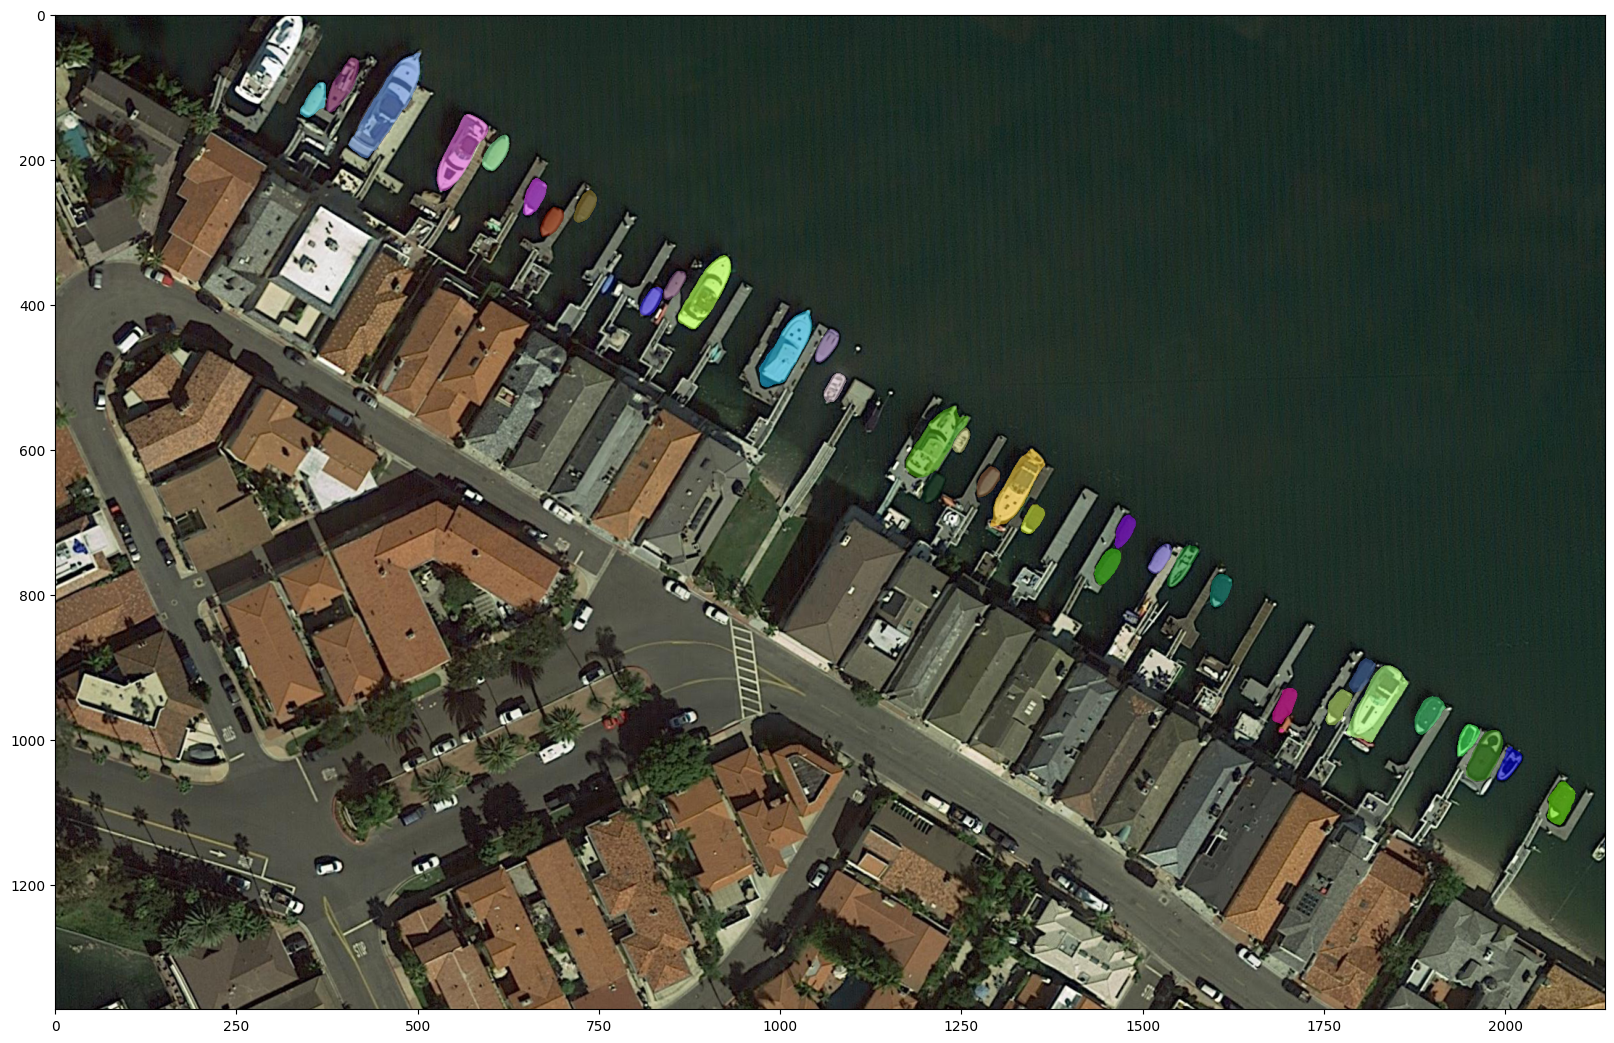

In [113]:
plt.figure(figsize=(20,20))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
#for box in input_boxes:
 #   show_box(box.cpu().numpy(), plt.gca())
plt.show()

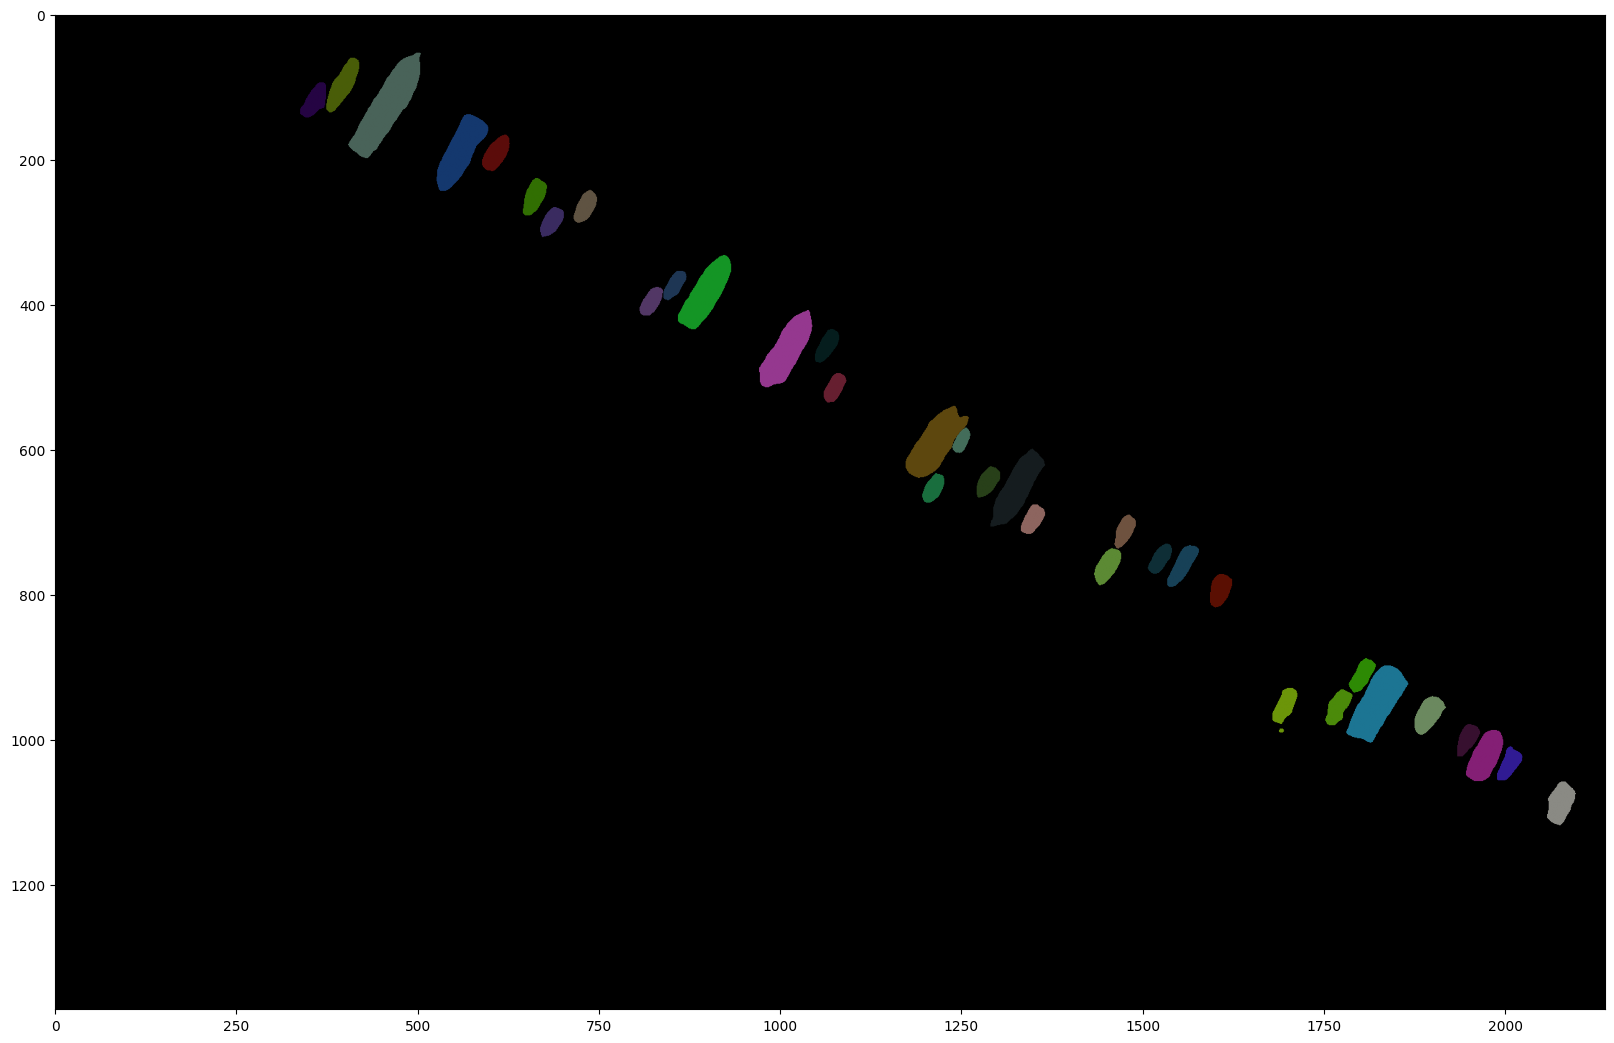

In [115]:
plt.figure(figsize=(20,20))
plt.imshow(map_img)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
plt.show()